# Table of Contents
- [Import Library](#import-library)
- [Read In CSV](#read-in-csv)

## Import Library

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

## Read In CSVs

In [2]:
eth = pd.read_csv('./ohlcv_daily.csv')
wiki_df = pd.read_csv('./ethereum_wikipedia.csv', index_col=0, parse_dates=True)

In [3]:
eth

trading_point     open     high      low    close        volume
0       2017-11-09   322.15   331.70   317.29   321.32  1.311815e+04
1       2017-11-10   321.32   325.61   291.00   298.66  3.441165e+04
2       2017-11-11   298.66   322.19   298.00   315.76  2.383674e+04
3       2017-11-12   315.76   318.98   300.11   306.10  4.820080e+04
4       2017-11-13   306.10   320.69   305.91   316.14  3.661350e+04
...            ...      ...      ...      ...      ...           ...
2250    2024-01-07  2241.70  2258.00  2207.30  2222.80  1.079937e+07
2251    2024-01-08  2222.70  2360.50  2168.00  2332.70  1.742889e+07
2252    2024-01-09  2333.50  2371.80  2228.70  2345.10  1.595371e+07
2253    2024-01-10  2346.70  2644.00  2341.60  2584.80  5.145508e+07
2254    2024-01-11  2585.70  2592.30  2571.40  2588.80  3.144844e+05

[2255 rows x 6 columns]

In [4]:
wiki_df

edit_count  sentiment  negative_sentiment
2014-02-25    0.066667  -0.066526            0.066667
2014-02-26    0.033333  -0.033243            0.033333
2014-02-27    0.033333  -0.033243            0.033333
2014-02-28    0.033333  -0.033243            0.033333
2014-03-01    0.033333  -0.033243            0.033333
...                ...        ...                 ...
2024-01-11    0.066667   0.057137            0.000000
2024-01-12    0.066667   0.057137            0.000000
2024-01-13    0.066667   0.057137            0.000000
2024-01-14    0.066667   0.057137            0.000000
2024-01-15    0.100000   0.024452            0.033333

[3612 rows x 3 columns]

In [5]:
eth.set_index('trading_point', inplace=True)

In [6]:
eth.index = pd.to_datetime(eth.index)

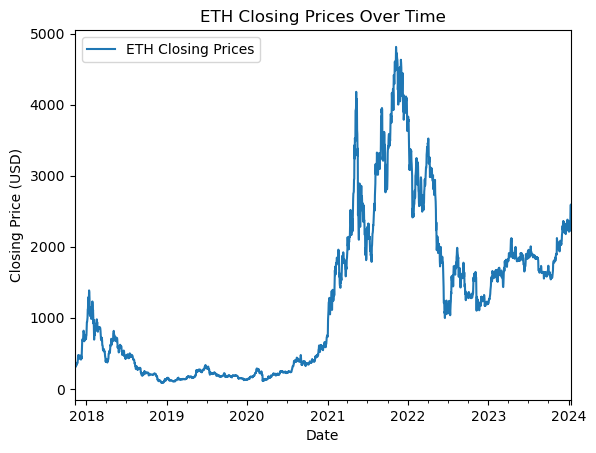

In [7]:
eth.plot.line(y='close', use_index=True, style='-', label='ETH Closing Prices')
plt.title('ETH Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)');

## Merge ETH and Sentiment DataFrames

In [8]:
# Merging based on date
eth = eth.merge(wiki_df, left_index=True, right_index=True)

In [9]:
eth['tomorrow'] = eth['close'].shift(-1)
eth

open     high      low    close        volume  edit_count  \
2017-11-09   322.15   331.70   317.29   321.32  1.311815e+04    0.900000   
2017-11-10   321.32   325.61   291.00   298.66  3.441165e+04    0.966667   
2017-11-11   298.66   322.19   298.00   315.76  2.383674e+04    0.966667   
2017-11-12   315.76   318.98   300.11   306.10  4.820080e+04    0.966667   
2017-11-13   306.10   320.69   305.91   316.14  3.661350e+04    1.100000   
...             ...      ...      ...      ...           ...         ...   
2024-01-07  2241.70  2258.00  2207.30  2222.80  1.079937e+07    0.100000   
2024-01-08  2222.70  2360.50  2168.00  2332.70  1.742889e+07    0.100000   
2024-01-09  2333.50  2371.80  2228.70  2345.10  1.595371e+07    0.100000   
2024-01-10  2346.70  2644.00  2341.60  2584.80  5.145508e+07    0.066667   
2024-01-11  2585.70  2592.30  2571.40  2588.80  3.144844e+05    0.066667   

            sentiment  negative_sentiment  tomorrow  
2017-11-09  -0.144123            0.261111    298.66  
2017-11-10  -0.177429            0.294444    315.76  
2017-11-11  -0.177429            0.294444    306.10  
2017-11-12  -0.177429            0.294444    316.14  
2017-11-13  -0.209260            0.327778    335.54  
...               ...                 ...       ...  
2024-01-07   0.023973            0.033333   2332.70  
2024-01-08   0.023973            0.033333   2345.10  
2024-01-09   0.023973            0.033333   2584.80  
2024-01-10   0.057137            0.000000   2588.80  
2024-01-11   0.057137            0.000000       NaN  

[2255 rows x 9 columns]

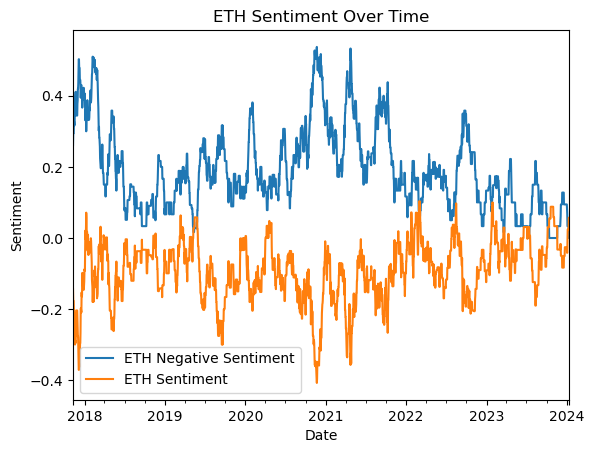

In [10]:
eth['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')

plt.title('ETH Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'sentiment_and_negative_sentiment.png'));

> This chart is showing that the positive sentiment for ETH in the early days was low while the negative sentiment was high but as time goes on the emotional sentiment towards ETH is shifting for the positive as the technology matures

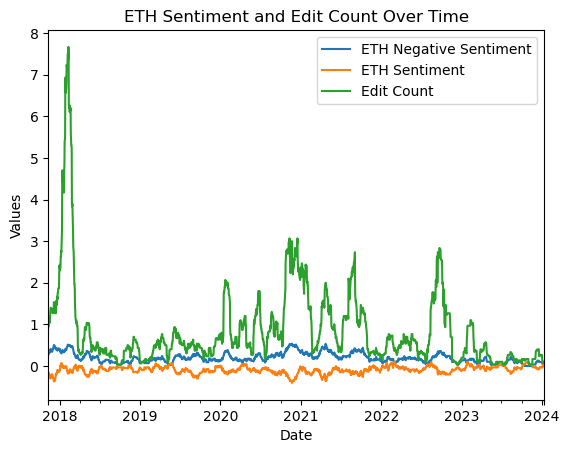

In [11]:
eth['negative_sentiment'].plot.line(use_index=True, style='-', label='ETH Negative Sentiment')
eth['sentiment'].plot.line(use_index=True, style='-', label='ETH Sentiment')
eth['edit_count'].plot.line(use_index=True, style='-', label='Edit Count')

plt.title('ETH Sentiment and Edit Count Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'sentiment_and_edit_count.png'));

> Less edits are being made per day as the sentiment grows positive over time

In [12]:
eth['target'] = (eth['tomorrow'] > eth['close']).astype(int)
eth['target'].value_counts()

1    1147
0    1108
Name: target, dtype: int64

## Autocorrelation

Description:

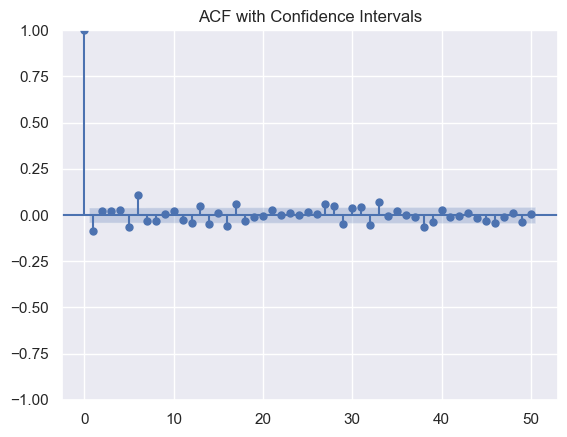

In [42]:
autocorrelation = eth['2017':].resample('D').mean().fillna(method='ffill')['close']
acf_plot = plot_acf(autocorrelation.diff().dropna(), lags=50, alpha=0.05, title='ACF with Confidence Intervals')

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'acf_plot.png'));

- If you observe the autocorrelation value for the present value with itself it is 1.0 since current value is dependent on current value.
- **Lower Bound Statistically Significant Lags:**
> Lags 2, 6, 14, 16, 29, 32, 48 exhibit autocorrelation values that are statistically significant and fall below the lower confidence interval. These lags suggest potential negative correlations beyond what would be expected by random chance.

- **Upper Bound Statistically Significant Lags:**
> Lags 7, 17, 27, 33 exhibit autocorrelation values that are statistically significant and exceed the upper confidence interval. These lags suggest potential positive correlations beyond what would be expected by random chance.

## Baseline RandomForest Model

In [13]:
predictors = ['close', 'volume', 'open', 'high', 'low', 'edit_count', 'sentiment', 'negative_sentiment']

# Define the RandomForestClassifier
rf = RandomForestClassifier(random_state=1)

# Define the parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10, 20, 50]
}

# Split your data into train and test sets
train = eth.iloc[:-200]
test = eth.iloc[-200:]

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='precision', cv=3)

# Fit the GridSearchCV object to find the best parameters
grid_search.fit(train[predictors], train['target'])

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to create the final model
final_rf = RandomForestClassifier(random_state=1, **best_params)

# Fit the final model
final_rf.fit(train[predictors], train['target'])

# Make predictions
preds = final_rf.predict(test[predictors])

# Evaluate precision
precision = precision_score(test['target'], preds)
print("Precision:", precision)

Best Parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Precision: 0.5409836065573771


## Backtest RandomForest Model

In [14]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="predictions")
    combined = pd.concat([test["target"], preds], axis=1)
    
    plt.figure(figsize=(12,6))
    
    plt.plot(combined.index, combined["target"], label="Target")
    plt.plot(combined.index, combined["predictions"], label="Predictions")
    plt.legend()

    if not os.path.exists(visualization_folder):
        os.makedirs(visualization_folder)

    save_path = os.path.join(visualization_folder, f"visualization_{len(os.listdir(visualization_folder)) + 1}.png")
    plt.savefig(save_path)
    
    plt.show()
    
    return combined

In [15]:
# 3 years worth of historical data we want to use before we start making predictions and make predictions every 6 months
def backtest(data, model, predictors, start=1095, step=150): 
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

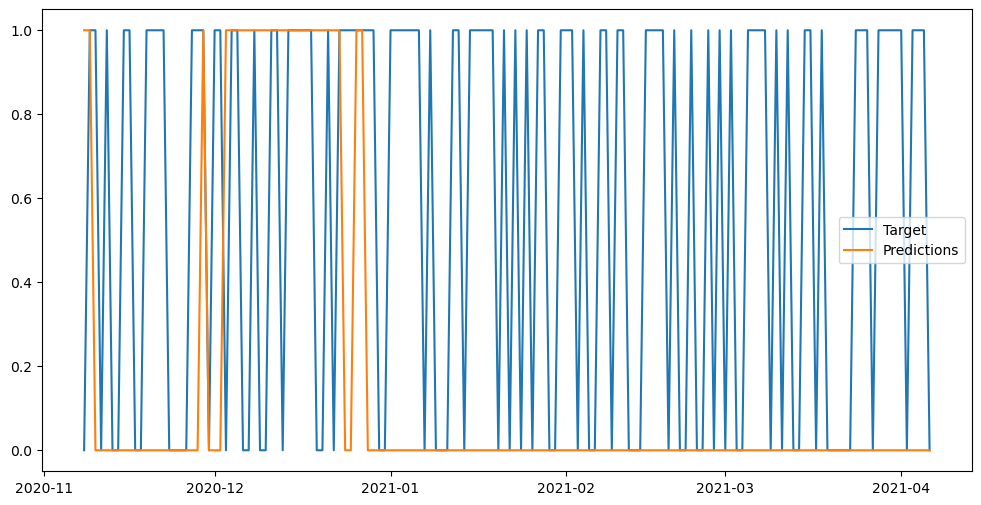

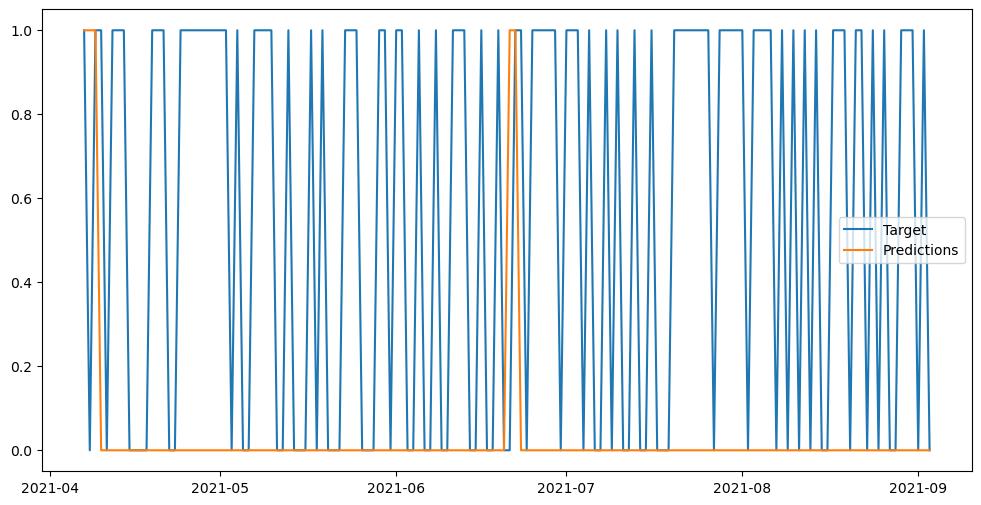

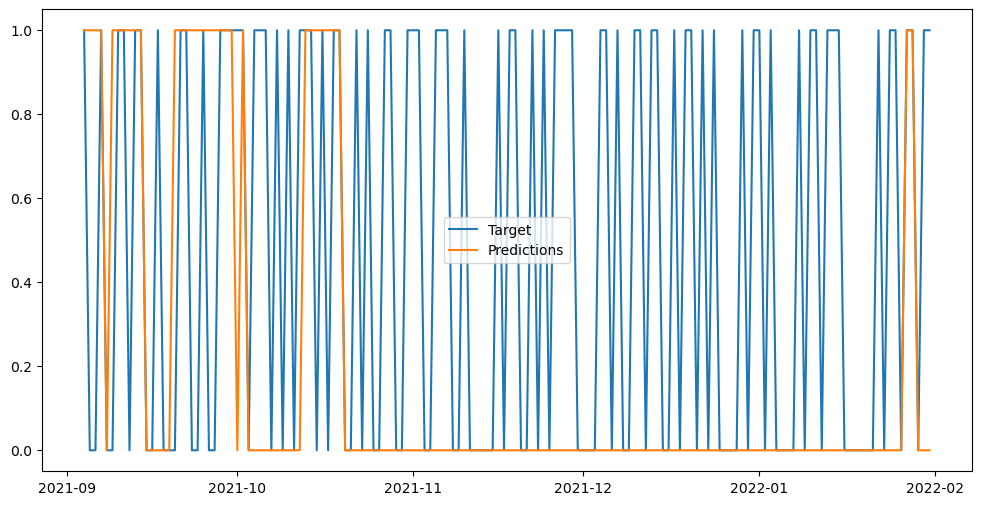

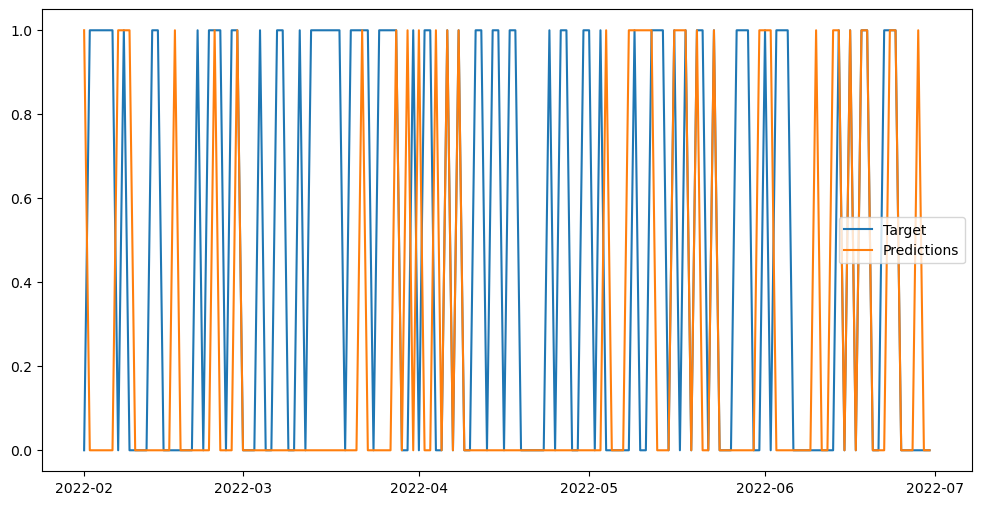

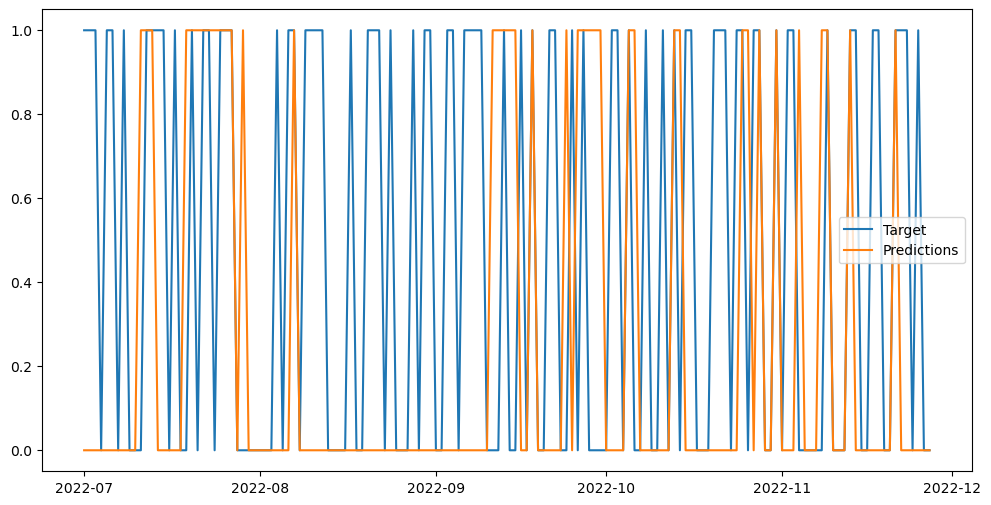

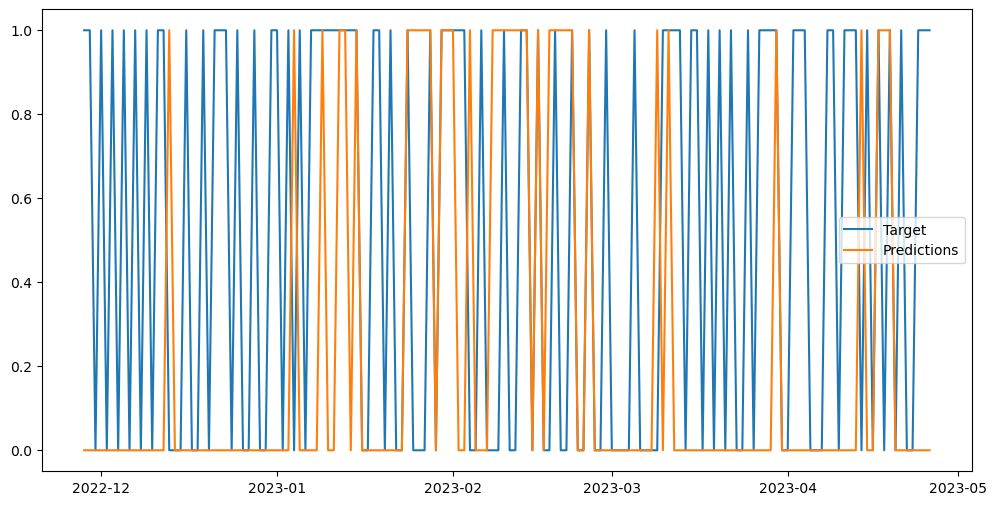

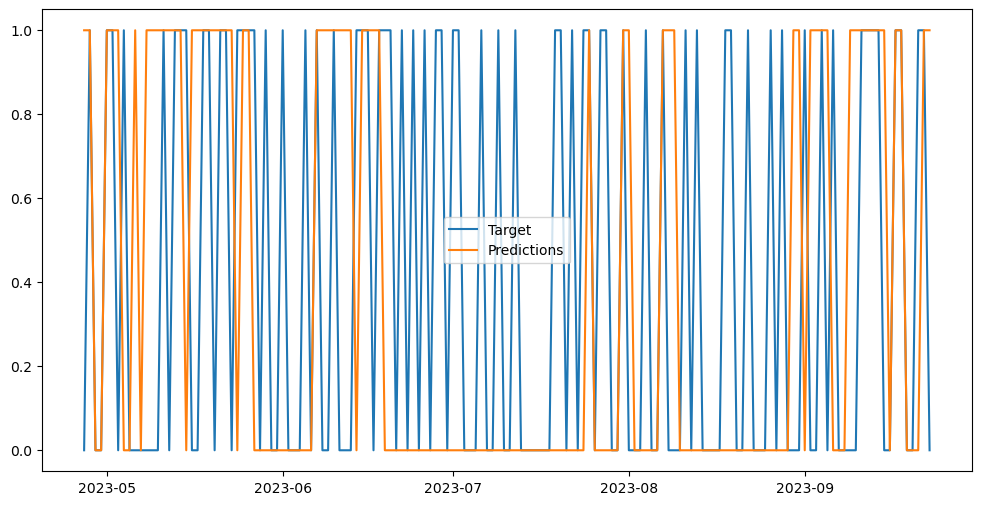

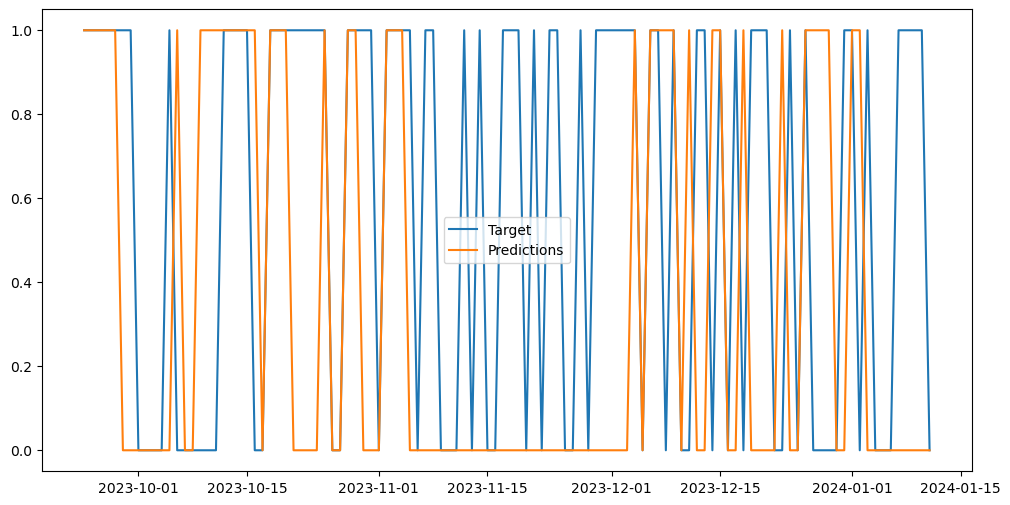

In [16]:
rf_predictions = backtest(eth, final_rf, predictors)

In [17]:
rf_predictions['predictions'].value_counts()

0    890
1    270
Name: predictions, dtype: int64

In [18]:
precision_score(rf_predictions["target"], rf_predictions["predictions"])

0.562962962962963

In [19]:
# Baseline
rf_predictions['target'].value_counts() / rf_predictions.shape[0]

1    0.517241
0    0.482759
Name: target, dtype: float64

## XGBoost Model

In [20]:
# Define the XGBClassifier
xgb = XGBClassifier(random_state=1)

# Define the parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Split your data into train and test sets
train = eth.iloc[:-200]
test = eth.iloc[-200:]

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='precision', cv=3)

# Fit the GridSearchCV object to find the best parameters
grid_search.fit(train[predictors], train['target'])

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best parameters to create the final model
final_xgb = XGBClassifier(random_state=1, **best_params)

# Fit the final model
final_xgb.fit(train[predictors], train['target'])

# Make predictions
preds = final_xgb.predict(test[predictors])

# Evaluate precision
precision = precision_score(test['target'], preds)
print("Precision:", precision)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.6}
Precision: 0.5555555555555556


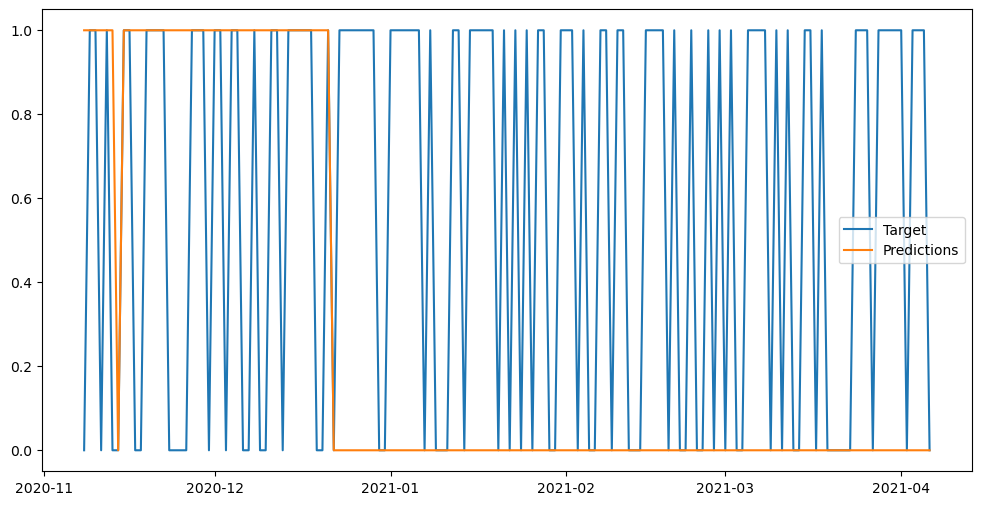

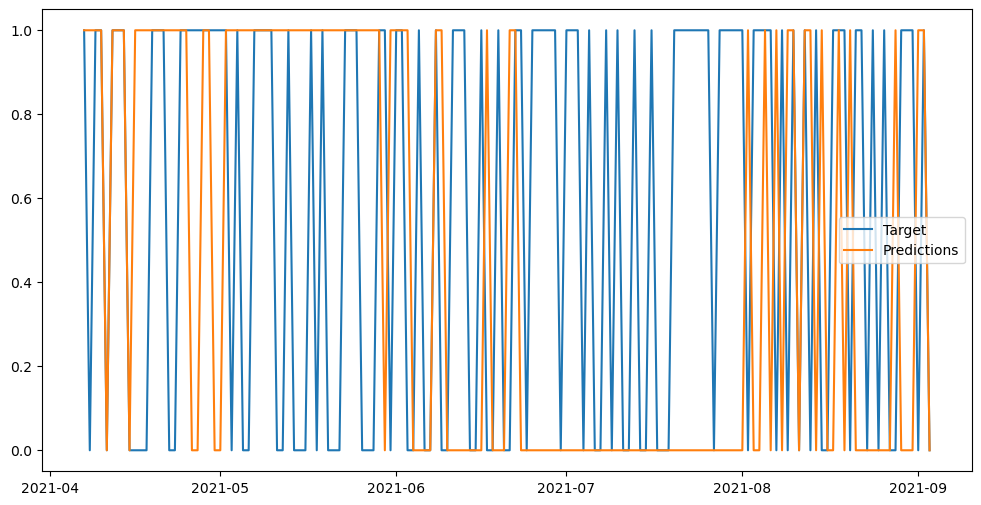

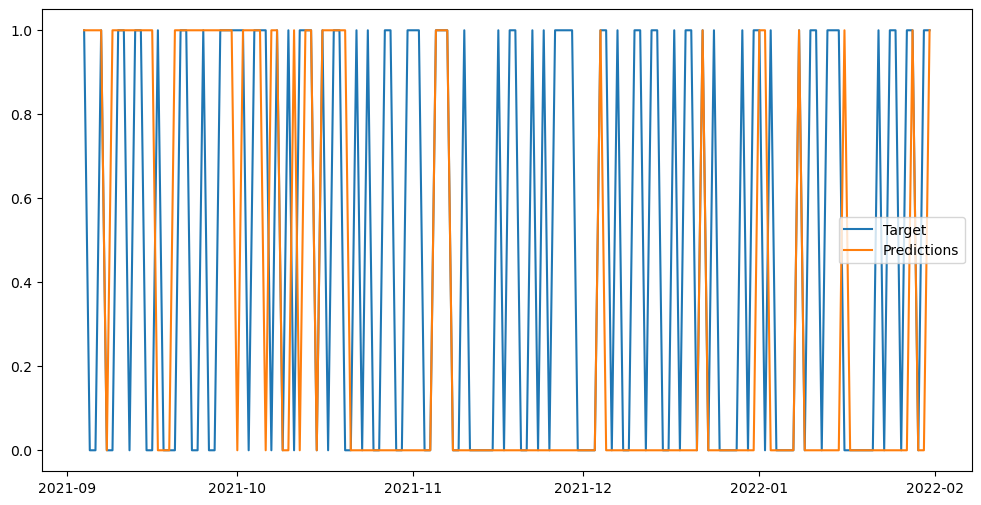

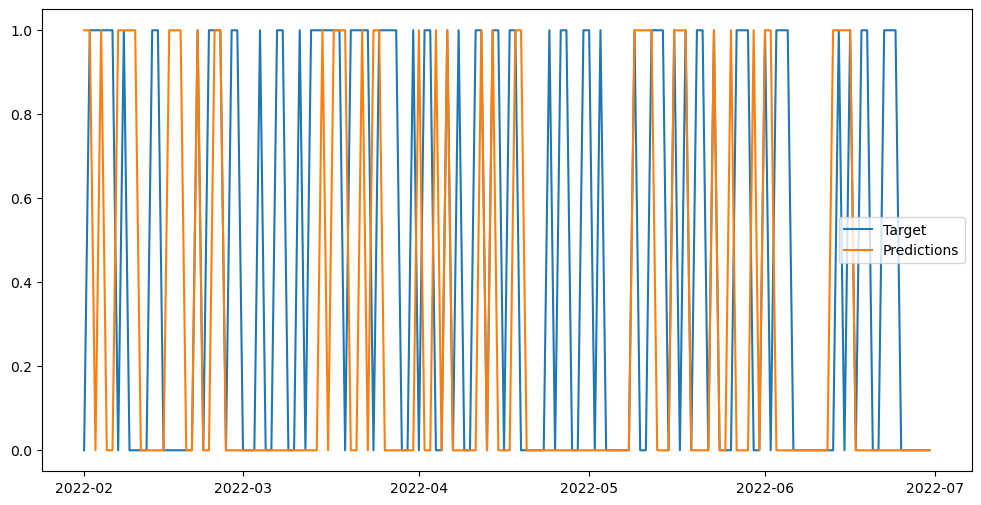

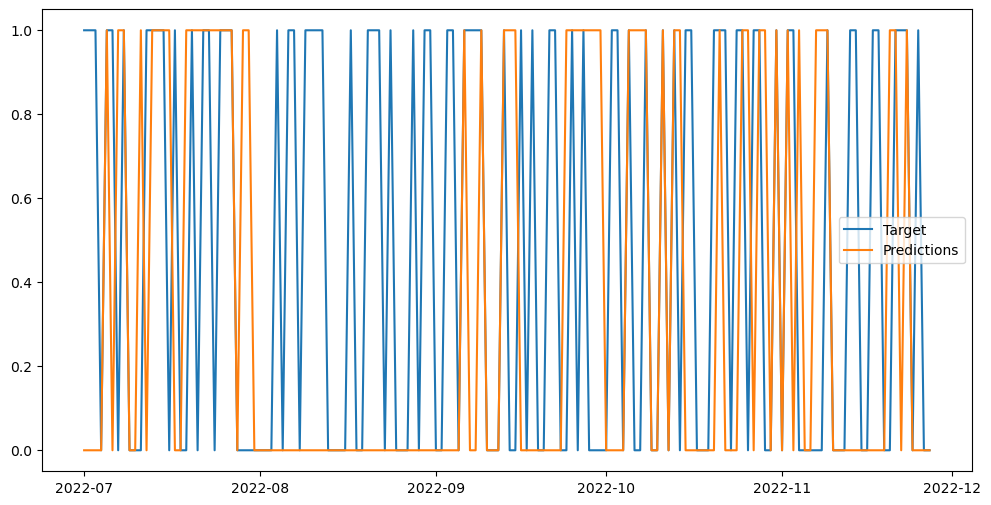

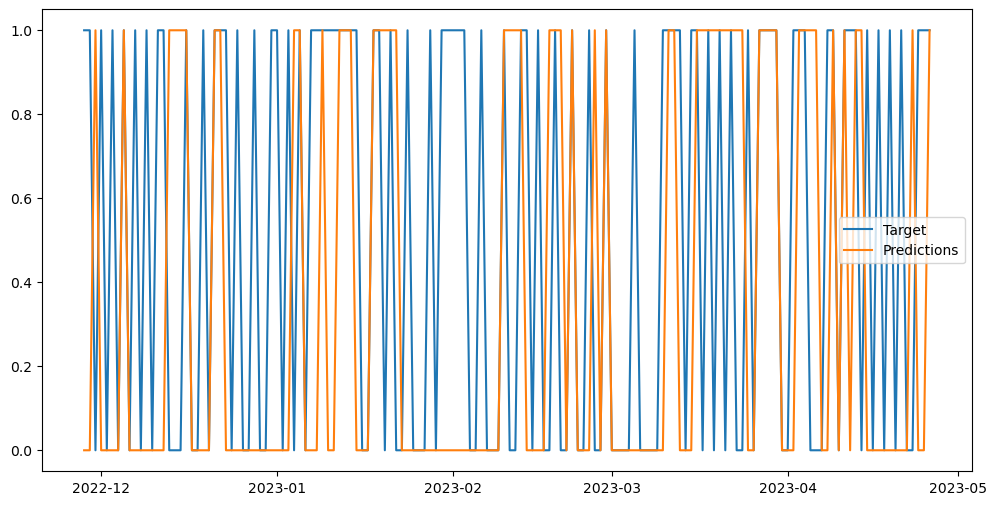

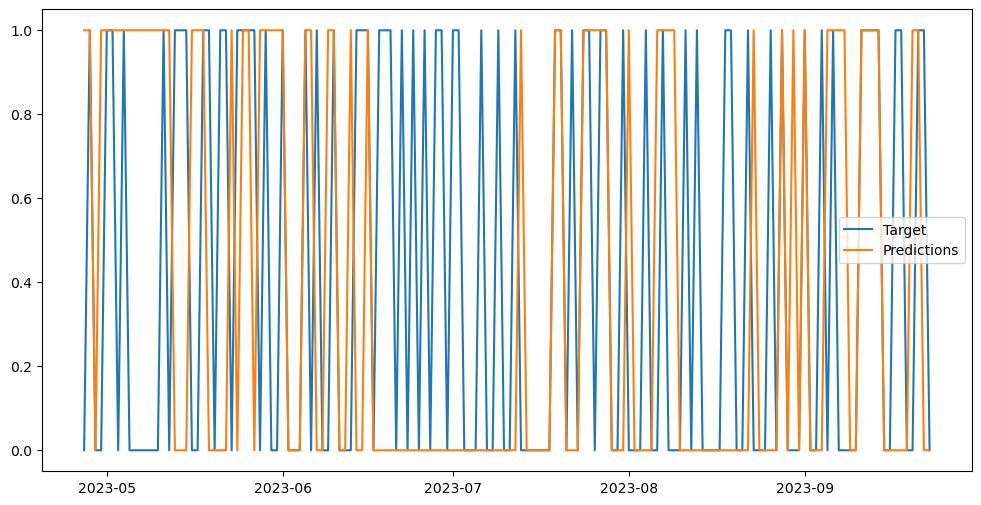

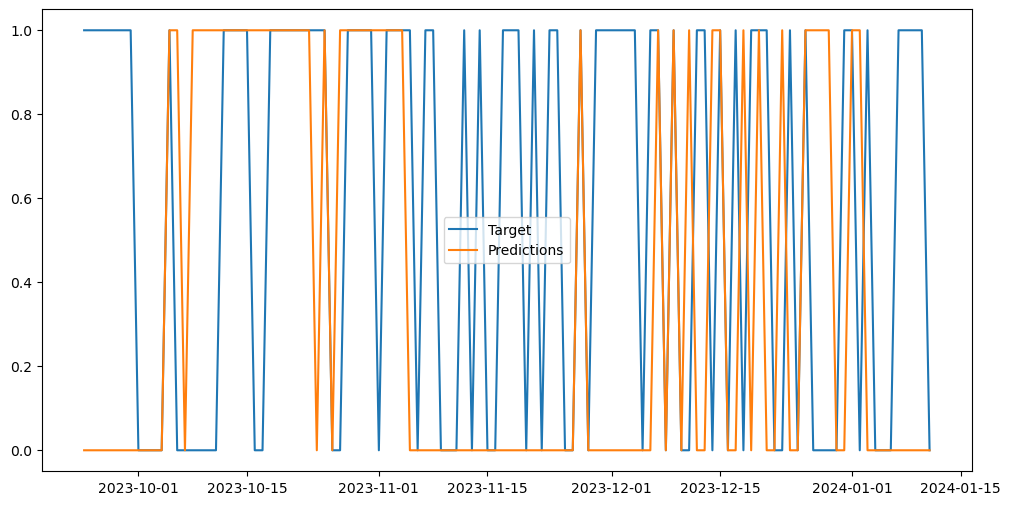

In [21]:
xgb_predictions = backtest(eth, final_xgb, predictors)

In [22]:
xgb_predictions['predictions'].value_counts()

0    749
1    411
Name: predictions, dtype: int64

In [23]:
precision_score(xgb_predictions["target"], xgb_predictions["predictions"])

0.5547445255474452

In [24]:
xgb_predictions['target'].value_counts() / xgb_predictions.shape[0] # baseline

1    0.517241
0    0.482759
Name: target, dtype: float64

In [25]:
def rolling_averages(eth):
    horizons = [2,7,60,365]
    new_predictors = ['close', 'sentiment', 'negative_sentiment']
    
    for horizon in horizons:
        roll_averages = eth.rolling(horizon, min_periods=1).mean()
        
        ratio_column = f"close_ratio_{horizon}"
        eth[ratio_column] = eth['close'] / roll_averages['close']
        
        edit_column = f"edit_{horizon}"
        eth[edit_column] = roll_averages['edit_count']
        
        rolling = eth.rolling(horizon, closed='left', min_periods=1).mean()
        trend_column = f"trend_{horizon}"
        eth[trend_column] = rolling['target']
        
        new_predictors += [ratio_column, trend_column, edit_column]
        
    return eth, new_predictors

In [26]:
eth, new_predictors = rolling_averages(eth.copy())

## XGBoost Model With New Predictors

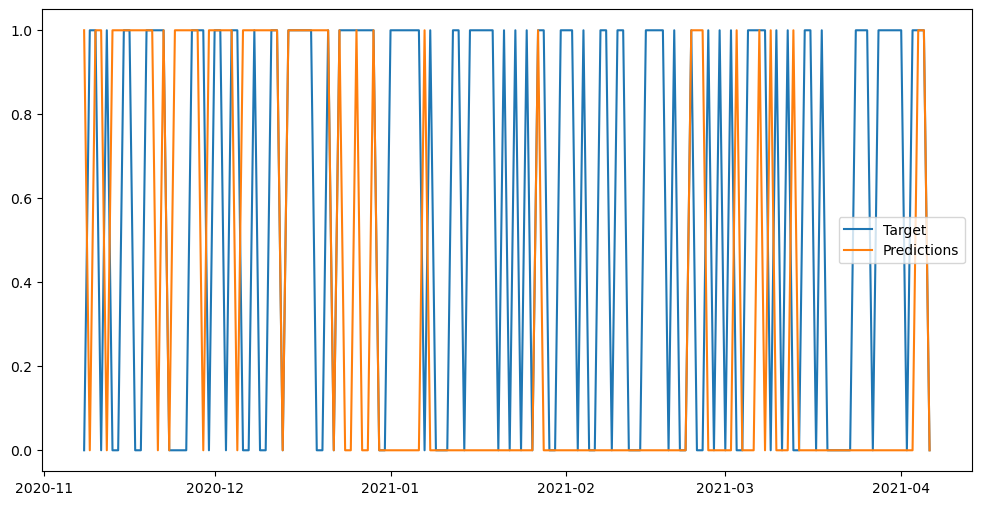

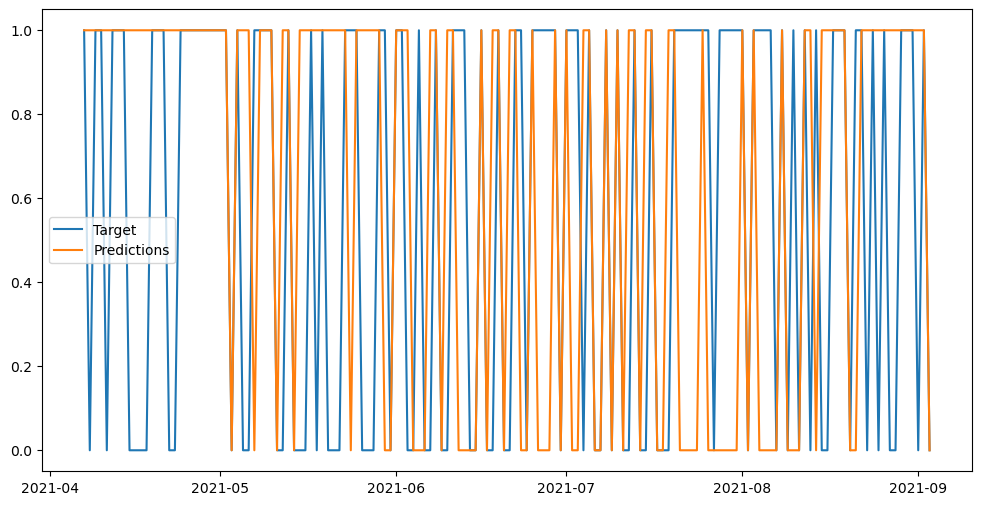

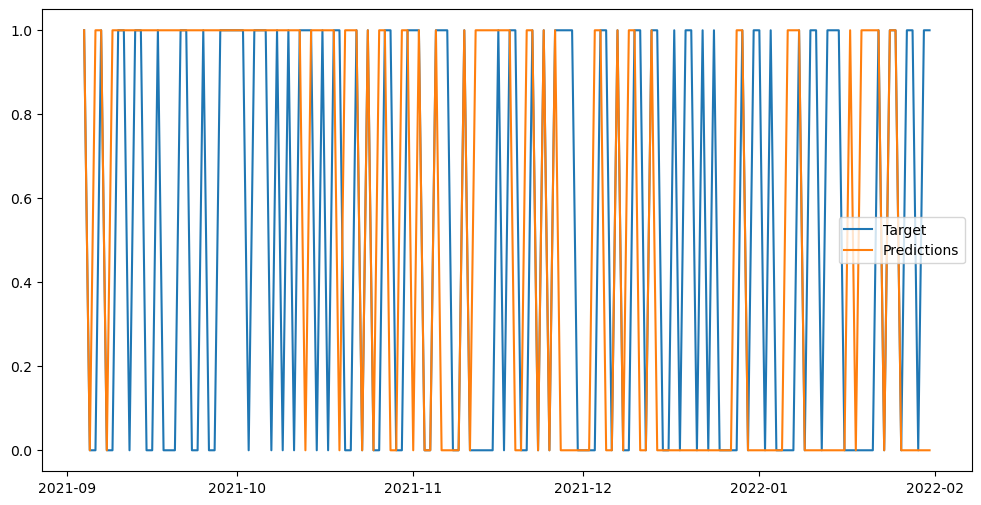

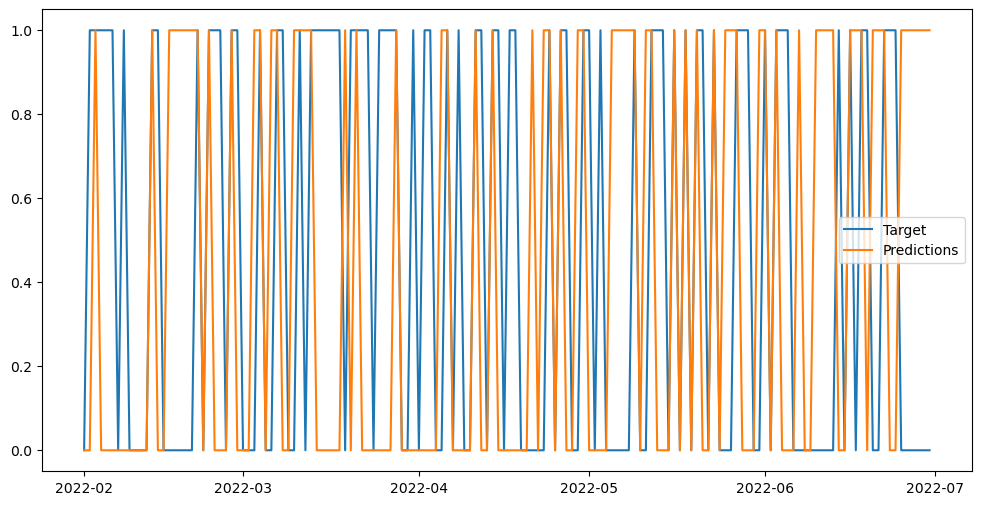

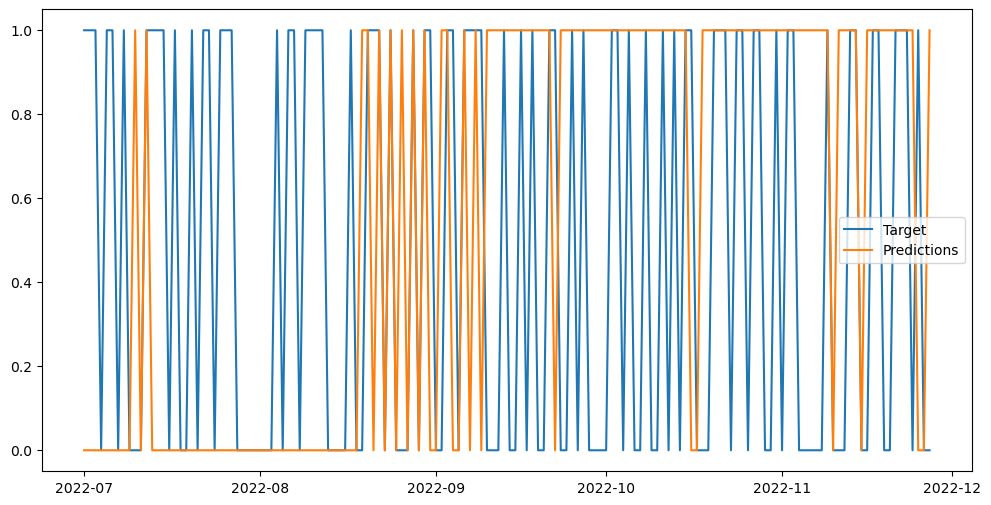

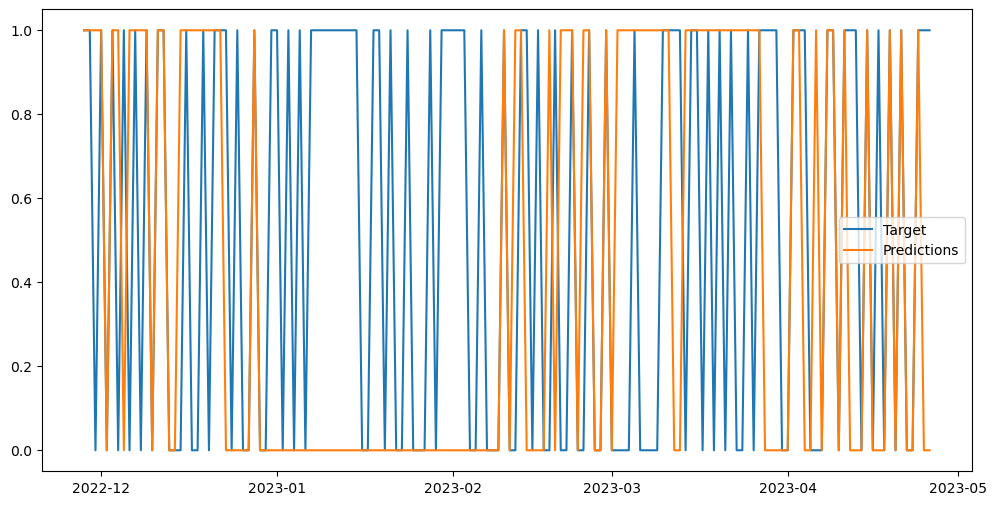

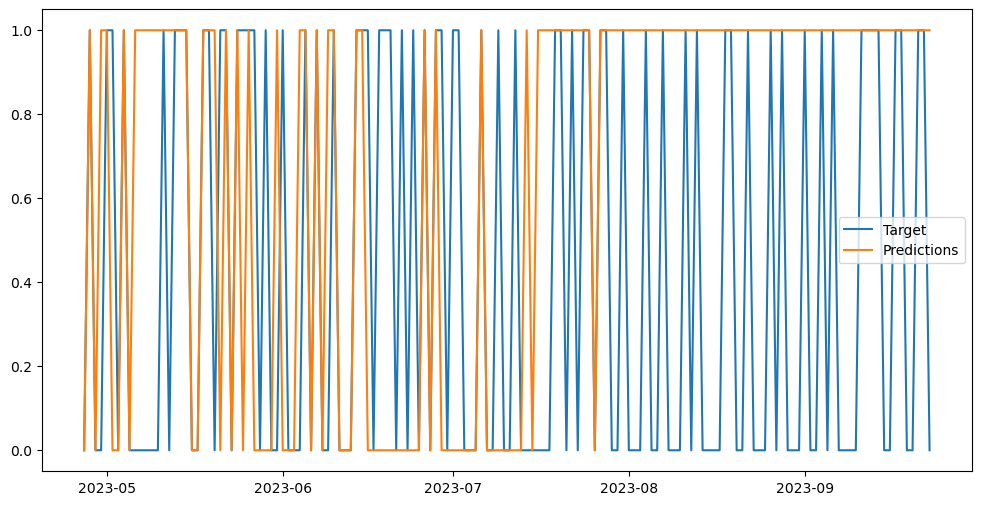

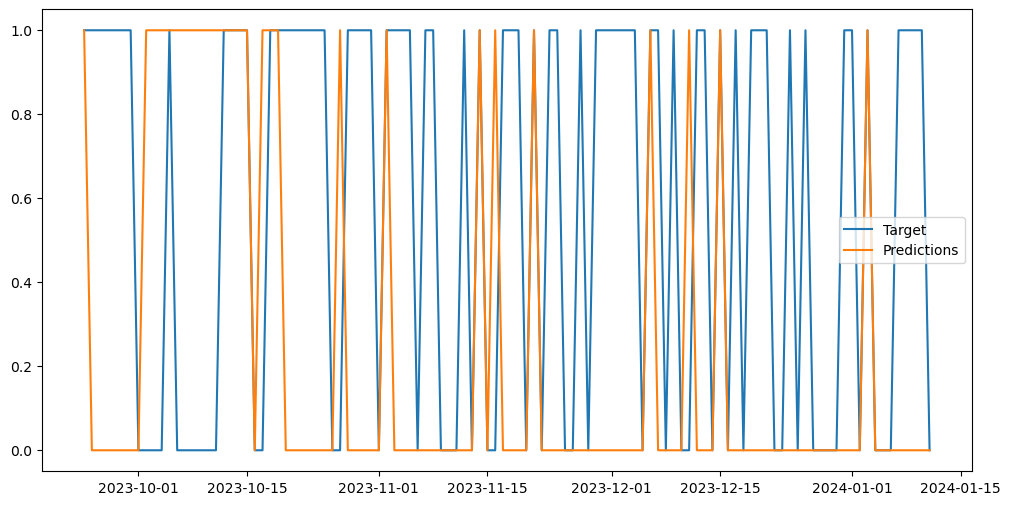

In [27]:
new_xgb_predictions = backtest(eth, final_xgb, new_predictors)

In [28]:
precision_score(new_xgb_predictions['target'], new_xgb_predictions['predictions'])

0.5244755244755245

## ARIMA (4,1,0) Model

In [45]:
arima2017hour = eth['2017':].resample('D').mean().fillna(method='ffill')['close']

adfuller(arima2017hour)[1]

0.6190294404168979

> With a high p-value of 0.61 on the ADF test, there is not sufficient evidence to claim this time series is stationary. More specifically, we fail to reject the null hypothesis of a unit root at conventional significance levels.

In [150]:
# 90% training / 10% testing
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

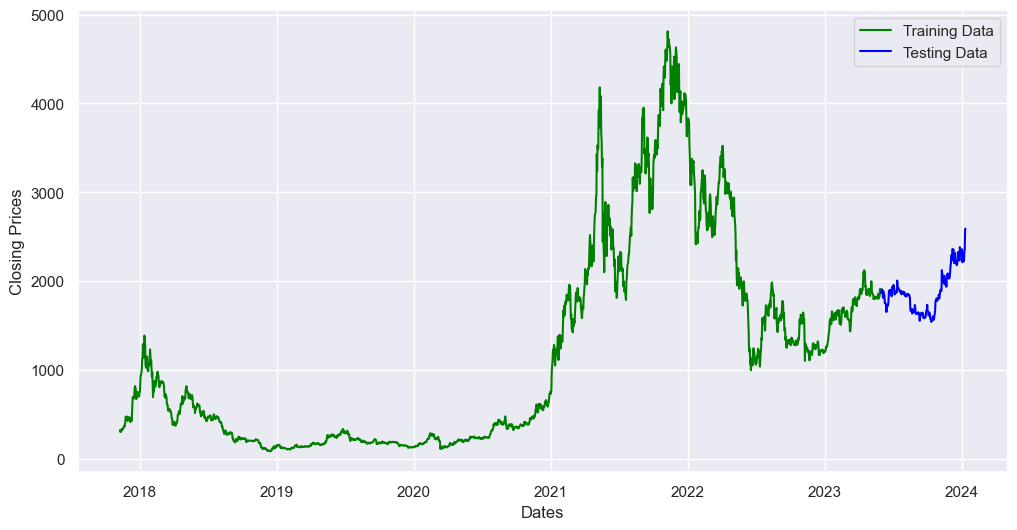

In [144]:
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(eth[0:to_row]['close'], 'green', label='Training Data')
plt.plot(eth[to_row:]['close'], 'blue', label='Testing Data')
plt.legend();

In [145]:
model_predictions = []

n_test_observations = len(testing_data)

In [146]:
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

In [147]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2254
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -12932.836
Date:                Wed, 17 Jan 2024   AIC                          25875.672
Time:                        16:35:28   BIC                          25904.272
Sample:                             0   HQIC                         25886.110
                               - 2254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0853      0.011     -7.851      0.000      -0.107      -0.064
ar.L2          0.0175      0.010      1.750      0.080      -0.002       0.037
ar.L3          0.0292      0.010      2.801      0.0

> This SARIMAX model has 4 Autoregressive (AR) terms and no Moving Average or seasonal components. All 4 AR coefficients are statistically significant, with the AR(1) term being negative and the others positive.

> The model exhibits heteroskedasticity according to the statistical test. The residuals also show evidence of non-normality based on the Jarque-Bera test, with the data being negatively skewed and having excess kurtosis.

> Overall, while this SARIMAX model fits the data reasonably well in sample based on the highly significant AR terms and AIC, there are indications of issues with heteroskedasticity and non-normality that may affect reliability of inference and forecasts.

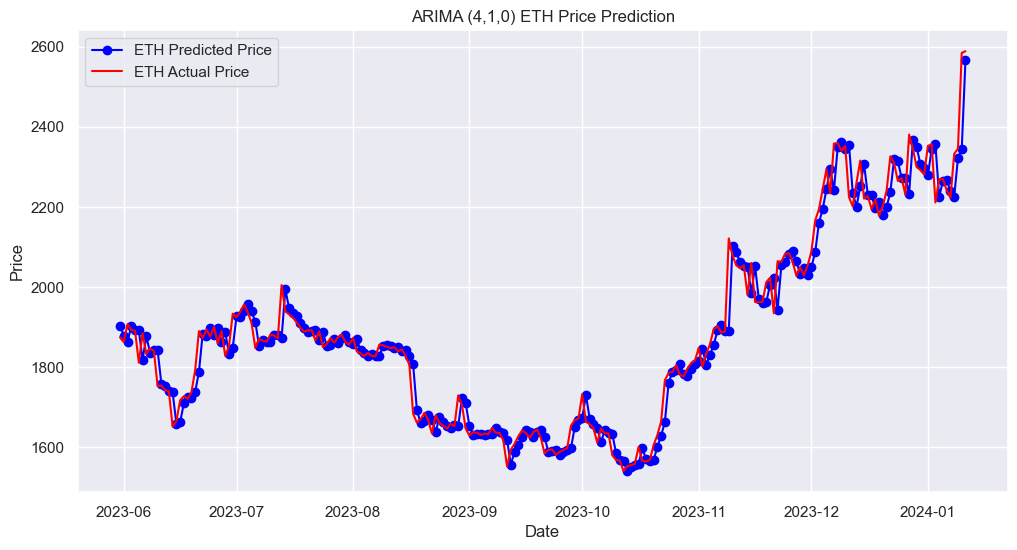

In [148]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (4,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'arima_410_prediction.png'));

In [149]:
mape = round(np.mean(np.abs(np.array(model_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

Mean Absolute Percentage Error: 0.016


> Around 1.6% mean absolute percentage error implies the model is about 98.4% accurate in predicting test observations.

## ARIMA (1,1,0) Model

In [157]:
# 90% training / 10% testing
to_row = int(len(eth)*0.9)

training_data = list(eth[0:to_row]['close'])
testing_data = list(eth[to_row:]['close'])

In [158]:
model_predictions = []

n_test_observations = len(testing_data)

In [159]:
for i in range(n_test_observations):
    model = ARIMA(training_data, order=(1,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)

In [160]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2254
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -12935.158
Date:                Wed, 17 Jan 2024   AIC                          25874.316
Time:                        16:36:38   BIC                          25885.756
Sample:                             0   HQIC                         25878.491
                               - 2254                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0854      0.011     -7.886      0.000      -0.107      -0.064
sigma2      5682.4185     54.108    105.020      0.000    5576.369    5788.468
Ljung-Box (L1) (Q):                   0.00   Jarque-

> This SARIMAX model has a single AR(1) term, which is statistically significant with a negative coefficient. No MA or seasonal components are included.

> The model exhibits heteroskedasticity and non-normal residuals, evidenced by test results showing significant p-values. Specifically, the residuals display negative skewness and excess kurtosis.

> The Ljung-Box test indicates no remaining autocorrelation in the residuals. And the overall fit seems reasonable given the highly significant AR coefficient and AIC.

> However, the presence of heteroskedasticity and non-normality may undermine reliability of inference and forecasting. Exploring transformations and additional parameters may improve model quality. But barely, the AR(1) component captures essential data dynamics.

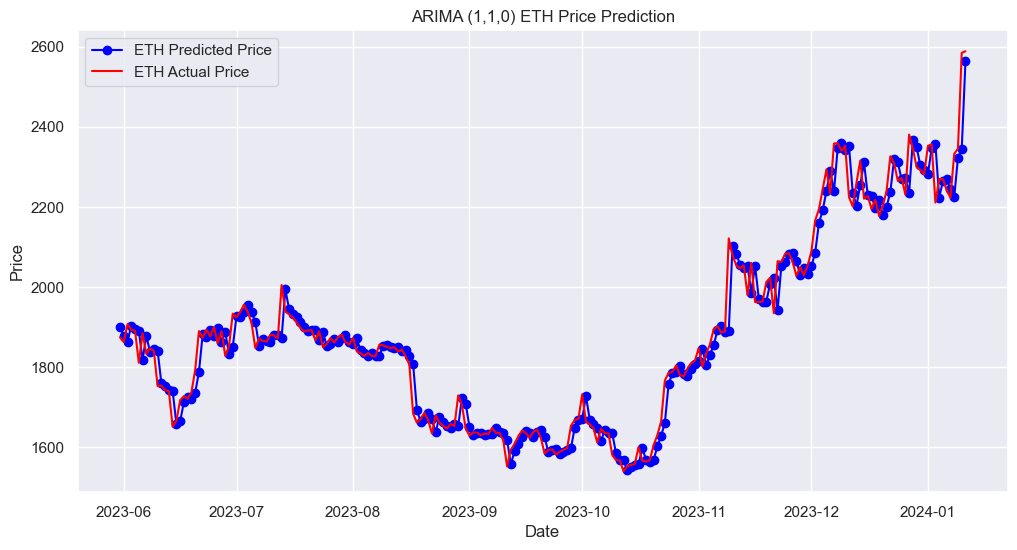

In [161]:
plt.figure(figsize=(12,6))
plt.grid(True)

date_range = eth[to_row:].index

plt.plot(date_range, model_predictions, color='blue', marker='o', linestyle='-', label='ETH Predicted Price')
plt.plot(date_range, testing_data, color='red', label='ETH Actual Price')
plt.title('ARIMA (1,1,0) ETH Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

visualization_folder = 'visualizations'
os.makedirs(visualization_folder, exist_ok=True)

plt.savefig(os.path.join(visualization_folder, 'arima_110_prediction.png'));

In [187]:
eth

open     high      low    close        volume  edit_count  \
2017-11-09   322.15   331.70   317.29   321.32  1.311815e+04    0.900000   
2017-11-10   321.32   325.61   291.00   298.66  3.441165e+04    0.966667   
2017-11-11   298.66   322.19   298.00   315.76  2.383674e+04    0.966667   
2017-11-12   315.76   318.98   300.11   306.10  4.820080e+04    0.966667   
2017-11-13   306.10   320.69   305.91   316.14  3.661350e+04    1.100000   
...             ...      ...      ...      ...           ...         ...   
2024-01-07  2241.70  2258.00  2207.30  2222.80  1.079937e+07    0.100000   
2024-01-08  2222.70  2360.50  2168.00  2332.70  1.742889e+07    0.100000   
2024-01-09  2333.50  2371.80  2228.70  2345.10  1.595371e+07    0.100000   
2024-01-10  2346.70  2644.00  2341.60  2584.80  5.145508e+07    0.066667   
2024-01-11  2585.70  2592.30  2571.40  2588.80  3.144844e+05    0.066667   

            sentiment  negative_sentiment  tomorrow  target  ...  trend_2  \
2017-11-09  -0.144123            0.261111    298.66       0  ...      NaN   
2017-11-10  -0.177429            0.294444    315.76       1  ...      0.0   
2017-11-11  -0.177429            0.294444    306.10       0  ...      0.5   
2017-11-12  -0.177429            0.294444    316.14       1  ...      0.5   
2017-11-13  -0.209260            0.327778    335.54       1  ...      0.5   
...               ...                 ...       ...     ...  ...      ...   
2024-01-07   0.023973            0.033333   2332.70       1  ...      0.0   
2024-01-08   0.023973            0.033333   2345.10       1  ...      0.5   
2024-01-09   0.023973            0.033333   2584.80       1  ...      1.0   
2024-01-10   0.057137            0.000000   2588.80       1  ...      1.0   
2024-01-11   0.057137            0.000000       NaN       0  ...      1.0   

            close_ratio_7    edit_7   trend_7  close_ratio_60   edit_60  \
2017-11-09       1.000000  0.900000       NaN        1.000000  0.900000   
2017-11-10       0.963450  0.933333  0.000000        0.963450  0.933333   
2017-11-11       1.012332  0.944444  0.500000        1.012332  0.944444   
2017-11-12       0.985956  0.950000  0.333333        0.985956  0.950000   
2017-11-13       1.014583  0.980000  0.500000        1.014583  0.980000   
...                   ...       ...       ...             ...       ...   
2024-01-07       0.977165  0.128571  0.428571        1.019580  0.215000   
2024-01-08       1.026755  0.104762  0.428571        1.068264  0.216111   
2024-01-09       1.032954  0.095238  0.428571        1.071766  0.217222   
2024-01-10       1.112364  0.090476  0.571429        1.176557  0.217778   
2024-01-11       1.092643  0.090476  0.571429        1.173550  0.218333   

            trend_60  close_ratio_365  edit_365  trend_365  
2017-11-09       NaN         1.000000  0.900000        NaN  
2017-11-10  0.000000         0.963450  0.933333   0.000000  
2017-11-11  0.500000         1.012332  0.944444   0.500000  
2017-11-12  0.333333         0.985956  0.950000   0.333333  
2017-11-13  0.500000         1.014583  0.980000   0.500000  
...              ...              ...       ...        ...  
2024-01-07  0.516667         1.224661  0.264840   0.501370  
2024-01-08  0.516667         1.283190  0.264566   0.501370  
2024-01-09  0.533333         1.288022  0.264292   0.501370  
2024-01-10  0.550000         1.417011  0.263562   0.501370  
2024-01-11  0.566667         1.416654  0.262831   0.501370  

[2255 rows x 22 columns]

In [162]:
mape = round(np.mean(np.abs(np.array(model_predictions) - np.array(testing_data)) / np.abs(testing_data)), 3)
print(f'Mean Absolute Percentage Error: {str(mape)}')

Mean Absolute Percentage Error: 0.016
